In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

!pip3 install autogluon.timeseries
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
# 設定 seaborn 主題，這會影響圖表的風格和顏色
sns.set_theme()  # Apply the default Seaborn theme
%matplotlib inline
# Libraries for statistical and scientific computing
import statsmodels.api as sm
from scipy import stats
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Defaulting to user installation because normal site-packages is not writeable


/Users/apple/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 使用pandas讀取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/xc90529/noninvasive_data_visualization/main/noninvasive_data.csv')

# To display the top 5 rows
df.head(5)
#CO-心輸出量
#CI - 心輸出指數
#SV - 舒張容積
#SVI - 舒張容積指數
#SVV - 舒張容積變異度
#SVR - 舒張容積阻力
#SVRI - 舒張容積指數阻力
#PR - 脈搏率
#SYS - 收縮壓
#DIA - 舒張壓
#MAP - 平均動脈壓

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.000000
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.333333
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.666667
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.000000
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.333333


In [3]:
# Calculating the Shock Index as PR / SYS
df['PR/SYS'] = df['PR'] / df['SYS']

# Displaying the first few rows of the dataframe to confirm the new variable
df.head()

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.000000,0.801724
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.333333,0.779661
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.666667,0.760331
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.000000,0.745763
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.333333,1.000000


In [11]:
# Remove the 'ID' column and the 'si1m' column from your DataFrame
columns_to_check = df.drop(columns=['ID', 'si1m', ])

# Use the duplicated method to find duplicate rows
duplicate_rows = df[df.duplicated(subset=columns_to_check, keep=False)]

# Print the content of duplicate rows
print("Duplicate rows:")
print(duplicate_rows)
# 要排除的列名
columns_to_exclude = ['ID', 'si1m']

# 选择除了要排除的列以外的其他列
columns_to_check = df.columns[~df.columns.isin(columns_to_exclude)]

# 使用 selected_columns 作为子集来检查重复行，保留第一个重复行
duplicate_rows_df = df[df.duplicated(subset=columns_to_check, keep='first')]

# 打印重复行的数量
print("重复行的数量：", duplicate_rows_df.shape[0])

# 打印重复行的内容
print("重复行：")
print(duplicate_rows_df)
# 重置索引
df.reset_index(drop=True, inplace=True)

# 在原始数据框 df 中删除重复行
df = df.drop(duplicate_rows_df.index)

# 现在 df 中已经不包含重复行
print(df)

Duplicate rows:
Empty DataFrame
Columns: [si1m, CO, CI, SV, SVI, SVV, SVR, SVRI, PR, SYS, DIA, MAP, ID, time, PR/SYS]
Index: []
重复行的数量： 0
重复行：
Empty DataFrame
Columns: [si1m, CO, CI, SV, SVI, SVV, SVR, SVRI, PR, SYS, DIA, MAP, ID, time, PR/SYS]
Index: []
      si1m   CO   CI  SV   SVI  SVV     SVR    SVRI   PR  SYS  DIA  MAP    ID  \
0        N  4.0  2.4  43  26.0   10  1673.0  2745.0   93  116   74   91   #_1   
1        N  4.0  2.4  43  26.0   10  1683.0  2760.0   92  118   74   91   #_1   
2        N  3.6  2.2  39  24.0   17  1978.0  3245.0   92  121   80   97   #_1   
3        N  3.6  2.2  41  25.0   17  1868.0  3065.0   88  118   76   93   #_1   
4        N  4.2  2.6  42  26.0   10  1335.0  2190.0  100  100   66   78   #_1   
...    ...  ...  ...  ..   ...  ...     ...     ...  ...  ...  ...  ...   ...   
39032    Y  4.8  2.7  48  26.0   24   768.0  1390.0  101   66   48   54  #_28   
39033    Y  4.3  2.4  42  23.0   24   750.0  1355.0  104   58   44   49  #_28   
39034    Y  4.7 

In [17]:
# 四舍五入 df 中的所有数值列到小数点后第五位
rounded_df = df.round(5)

rounded_df.head()

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.00000,0.80172
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.33333,0.77966
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.66667,0.76033
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.00000,0.74576
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.33333,1.00000


相關係數分析

In [18]:
# 將 'si1m' 欄的 'Y' 轉換為 1，'N' 轉換為 0
rounded_df['si1m'] = rounded_df['si1m'].map({'Y': 1, 'N': 0})

# 计算除 'ID' 'si1m' 列外的所有列的 Pearson 相关系数
correlation_matrix = rounded_df.drop(['ID', 'si1m'], axis=1).corr()

# 打印与 'PR/SYS' 相关的相关系数
print(correlation_matrix['PR/SYS'])


CO        0.075229
CI        0.088904
SV       -0.367625
SVI      -0.407779
SVV       0.234460
SVR      -0.258130
SVRI     -0.187680
PR        0.743472
SYS      -0.708988
DIA      -0.183142
MAP      -0.494982
time     -0.238417
PR/SYS    1.000000
Name: PR/SYS, dtype: float64


In [19]:
## 計算'si1m'和'PR/SYS'相關性
import scipy.stats

# 确保 si1m 是二元分类变量
point_biserial_corr = scipy.stats.pointbiserialr(rounded_df['si1m'], rounded_df['PR/SYS'])
print("Point Biserial Correlation between 'si1m' and 'PR/SYS':", point_biserial_corr.correlation)

##選擇PR,SYS,SVI,MAP,si1m來預測PR/SYS

Point Biserial Correlation between 'si1m' and 'PR/SYS': 0.6480595105599248


In [23]:
# 選擇病人 #_9 的數據
id9 = rounded_df[rounded_df['ID'] == '#_9']
id9

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
6590,0,3.6,2.3,46,29.0,19,1444.44444,2260.86957,78,91,57,69,#_9,120.00000,0.85714
6591,0,3.8,2.4,42,27.0,35,1452.63158,2300.00000,90,94,60,73,#_9,120.33333,0.95745
6592,0,4.3,2.8,48,31.0,22,1227.90698,1885.71429,89,88,59,70,#_9,120.66667,1.01136
6593,0,4.4,2.9,47,30.0,20,1236.36364,1875.86207,95,92,59,72,#_9,121.00000,1.03261
6594,0,4.2,2.7,44,28.0,22,1238.09524,1925.92593,96,89,56,69,#_9,121.33333,1.07865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8796,0,3.0,2.0,42,27.0,21,1840.00000,2760.00000,73,90,61,73,#_9,1393.00000,0.81111
8797,0,2.5,1.6,35,22.0,21,2016.00000,3150.00000,73,81,56,67,#_9,1393.33333,0.90123
8798,0,3.4,2.2,46,30.0,34,1694.11765,2618.18182,74,89,63,76,#_9,1394.66667,0.83146
8799,0,2.4,1.5,35,22.0,34,1766.66667,2826.66667,68,70,44,57,#_9,1395.00000,0.97143


填充id9 120~1395的缺失值，以0.33333為單位

In [24]:
#找出time 120~1395 從120開始以1為單位 所有的缺失值
# Ensure 'time' is sorted
data_sorted =id9.sort_values(by='time')

# Generate the full range of desired time values
full_time_range = pd.Series(range(120, 1396))

# Find missing time values
missing_times = full_time_range[~full_time_range.isin(data_sorted['time'])]

# Print the first 10 missing time values
missing_times.head(10).tolist()


[124, 125, 126, 127, 128, 133, 134, 151, 159, 182]

In [25]:
# 從120開始以1為單位 所有的缺失值用上一筆資料進行填充
# Correct the process of filling values considering fractional times properly
filled_values_corrected_proper = pd.DataFrame()

for missing_time in missing_times:
    # Find the closest previous time point, correctly handling fractional times
    closest_time = data_sorted[data_sorted['time'] < missing_time]['time'].max()
    # Copy the data from the closest time point
    row_to_copy = data_sorted[data_sorted['time'] == closest_time].copy()
    # Update the time to the missing time
    row_to_copy['time'] = missing_time
    # Append to the corrected filled values DataFrame
    filled_values_corrected_proper = pd.concat([filled_values_corrected_proper, row_to_copy], ignore_index=True)

# Concatenate the original sorted data with the properly filled values and sort by time
final_data_properly_filled = pd.concat([data_sorted, filled_values_corrected_proper], ignore_index=True).sort_values(by='time')

# To ensure accuracy, let's check the filled values, especially around the first few missing times, with accurate reference points
check_points = [120, 120.33333, 120.66667, 121]  # Reference points to check if the fill was correct
final_check = final_data_properly_filled[final_data_properly_filled['time'].isin(check_points + missing_times.tolist())]

final_check.head(10)  # Displaying more rows to observe the transition around the mentioned check points and first few filled values


,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,0,3.6,2.3,46,29.0,19,1444.44444,2260.86957,78,91,57,69,#_9,120.00000,0.85714
1,0,3.8,2.4,42,27.0,35,1452.63158,2300.00000,90,94,60,73,#_9,120.33333,0.95745
2,0,4.3,2.8,48,31.0,22,1227.90698,1885.71429,89,88,59,70,#_9,120.66667,1.01136
3,0,4.4,2.9,47,30.0,20,1236.36364,1875.86207,95,92,59,72,#_9,121.00000,1.03261
2211,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,124.00000,1.02174
2212,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,125.00000,1.02174
2213,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,126.00000,1.02174
2214,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,127.00000,1.02174
2215,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,128.00000,1.02174
2216,0,5.0,3.2,56,36.0,12,992.00000,1550.00000,90,89,52,66,#_9,133.00000,1.01124


In [26]:
# Generate a list of the specific decimal time points from 120 to 1395, adding .3333333 to each
specific_decimal_times = [x + 0.33333 for x in range(120, 1396)]

# Check which of these specific times are missing in the final_data_properly_filled DataFrame
missing_specific_decimal_times = [time for time in specific_decimal_times if time not in final_data_properly_filled['time'].round(5).tolist()]

# Display the missing times
missing_specific_decimal_times[:10]


[123.33333,
 124.33333,
 125.33333,
 126.33333,
 127.33333,
 128.33333,
 133.33333,
 150.33333,
 151.33333,
 158.33333]

In [27]:
# Initialize a DataFrame to hold the filled values for missing specific decimal times
filled_values_for_missing_decimal = pd.DataFrame()

# Iterate over the sorted list of missing specific decimal times
for missing_time in missing_specific_decimal_times:
    # Find the closest previous time point
    closest_time = final_data_properly_filled[final_data_properly_filled['time'] < missing_time]['time'].max()
    # Copy the data from the closest time point
    row_to_copy = final_data_properly_filled[final_data_properly_filled['time'] == closest_time].copy()
    # Update the time to the missing time
    row_to_copy['time'] = missing_time
    # Append to the filled values DataFrame
    filled_values_for_missing_decimal = pd.concat([filled_values_for_missing_decimal, row_to_copy], ignore_index=True)

# Concatenate the original data with the filled values and sort by 'time'
final_data_with_filled_decimal = pd.concat([final_data_properly_filled, filled_values_for_missing_decimal], ignore_index=True).sort_values(by='time')

# Checking a sample of the filled values
final_data_with_filled_decimal[final_data_with_filled_decimal['time'].isin(missing_specific_decimal_times)].head()


,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
2526,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,123.33333,1.02174
2527,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,124.33333,1.02174
2528,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,125.33333,1.02174
2529,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,126.33333,1.02174
2530,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,127.33333,1.02174


In [28]:
# Generate a list of the specific decimal time points from 120.66666666667 to 1395, adding .66666666667 to each integer
specific_decimal_times_66667 = [120.66667 + x for x in range(0, 1394 - 120 + 1)]

# Check which of these specific times are missing in the final_data_with_filled_decimal DataFrame
missing_specific_decimal_times_66667 = [time for time in specific_decimal_times_66667 if time not in final_data_with_filled_decimal['time'].round(11).tolist()]

# Display the missing times
missing_specific_decimal_times_66667[:10]


[123.66667,
 124.66667,
 125.66667,
 126.66667,
 127.66667,
 133.66667,
 150.66667,
 158.66667,
 176.66667,
 181.66667]

In [29]:
# Adjust the list of missing specific decimal times to exclude any time points beyond 1395
adjusted_missing_times_66667 = [time for time in missing_specific_decimal_times_66667 if time <= 1395]

# Initialize a new DataFrame for adjusted filling
adjusted_filled_values_for_missing_decimal_66667 = pd.DataFrame()

# Ensure the time column is rounded to match the precision of missing times for accurate comparison
final_data_with_filled_decimal['time'] = final_data_with_filled_decimal['time'].round(11)

# Iterate over the adjusted list of missing specific decimal times ending with .66667
for missing_time in adjusted_missing_times_66667:
    # Find the closest previous time point
    closest_time = final_data_with_filled_decimal[final_data_with_filled_decimal['time'] < missing_time]['time'].max()
    # Copy the data from the closest time point
    row_to_copy = final_data_with_filled_decimal[final_data_with_filled_decimal['time'] == closest_time].copy()
    # Update the time to the missing time
    row_to_copy['time'] = missing_time
    # Append to the filled values DataFrame
    adjusted_filled_values_for_missing_decimal_66667 = pd.concat([adjusted_filled_values_for_missing_decimal_66667, row_to_copy], ignore_index=True)

# Concatenate the current data with the adjusted filled values and sort by 'time'
final_data_adjusted_with_all_filled = pd.concat([final_data_with_filled_decimal, adjusted_filled_values_for_missing_decimal_66667], ignore_index=True).sort_values(by='time')

# Show a sample of the filled values to verify, focusing on the adjusted range
final_data_adjusted_with_all_filled[final_data_adjusted_with_all_filled['time'].isin(adjusted_missing_times_66667)].head()


,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
3184,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,123.66667,1.02174
3185,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,124.66667,1.02174
3186,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,125.66667,1.02174
3187,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,126.66667,1.02174
3188,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,127.66667,1.02174


In [30]:
final_data_adjusted_with_all_filled

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,0,3.6,2.3,46,29.0,19,1444.44444,2260.86957,78,91,57,69,#_9,120.00000,0.85714
1,0,3.8,2.4,42,27.0,35,1452.63158,2300.00000,90,94,60,73,#_9,120.33333,0.95745
2,0,4.3,2.8,48,31.0,22,1227.90698,1885.71429,89,88,59,70,#_9,120.66667,1.01136
3,0,4.4,2.9,47,30.0,20,1236.36364,1875.86207,95,92,59,72,#_9,121.00000,1.03261
4,0,4.2,2.7,44,28.0,22,1238.09524,1925.92593,96,89,56,69,#_9,121.33333,1.07865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,0,2.5,1.6,35,22.0,21,2016.00000,3150.00000,73,81,56,67,#_9,1394.00000,0.90123
3180,0,2.5,1.6,35,22.0,21,2016.00000,3150.00000,73,81,56,67,#_9,1394.33333,0.90123
3181,0,3.4,2.2,46,30.0,34,1694.11765,2618.18182,74,89,63,76,#_9,1394.66667,0.83146
3182,0,2.4,1.5,35,22.0,34,1766.66667,2826.66667,68,70,44,57,#_9,1395.00000,0.97143


In [31]:
# 進行特徵選取 
##選擇PR,SYS,SVI,MAP,si1m來預測PR/SYS
selected_features_df = final_data_adjusted_with_all_filled[['si1m', 'SVI', 'PR', 'SYS', 'MAP',  'PR/SYS',  'time', 'ID']]

selected_features_df 

,si1m,SVI,PR,SYS,MAP,PR/SYS,time,ID
0,0,29.0,78,91,69,0.85714,120.00000,#_9
1,0,27.0,90,94,73,0.95745,120.33333,#_9
2,0,31.0,89,88,70,1.01136,120.66667,#_9
3,0,30.0,95,92,72,1.03261,121.00000,#_9
4,0,28.0,96,89,69,1.07865,121.33333,#_9
...,...,...,...,...,...,...,...,...
3179,0,22.0,73,81,67,0.90123,1394.00000,#_9
3180,0,22.0,73,81,67,0.90123,1394.33333,#_9
3181,0,30.0,74,89,76,0.83146,1394.66667,#_9
3182,0,22.0,68,70,57,0.97143,1395.00000,#_9


In [32]:
# 查看 si1m 變相的數量
si1m_counts = selected_features_df["si1m"].value_counts()

# 顯示 0 和 1 的數量
print(si1m_counts)

si1m
0    3610
1     217
Name: count, dtype: int64


In [ ]:
# 將時間填充好且特徵選取過後的數據，另存到桌面上 CSV 文件
selected_features_df .to_csv('~/Desktop/id9_Fin_0402.csv')


In [34]:
# 設置基本時間
base_datetime = pd.Timestamp('2024-01-01 00:00:00')

# 定義轉換函數
def convert_time(time_float):
    # 分離整數和小數部分
    minutes = int(time_float)
    seconds = round((time_float % 1) * 60)  # 四捨五入到最近的整數以避免浮點誤差
    return base_datetime + pd.Timedelta(minutes=minutes) + pd.Timedelta(seconds=seconds)

# 應用轉換
selected_features_df['timestamp'] = selected_features_df['time'].apply(convert_time)

# 展示轉換後的結果
selected_features_df[['time', 'timestamp']].head()


/var/folders/km/k90jpm1s7t1crdhzmztclmy80000gn/T/ipykernel_7447/1608870594.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df['timestamp'] = selected_features_df['time'].apply(convert_time)


,time,timestamp
0,120.00000,2024-01-01 02:00:00
1,120.33333,2024-01-01 02:00:20
2,120.66667,2024-01-01 02:00:40
3,121.00000,2024-01-01 02:01:00
4,121.33333,2024-01-01 02:01:20


In [35]:
selected_features_df

,si1m,SVI,PR,SYS,MAP,PR/SYS,time,ID,timestamp
0,0,29.0,78,91,69,0.85714,120.00000,#_9,2024-01-01 02:00:00
1,0,27.0,90,94,73,0.95745,120.33333,#_9,2024-01-01 02:00:20
2,0,31.0,89,88,70,1.01136,120.66667,#_9,2024-01-01 02:00:40
3,0,30.0,95,92,72,1.03261,121.00000,#_9,2024-01-01 02:01:00
4,0,28.0,96,89,69,1.07865,121.33333,#_9,2024-01-01 02:01:20
...,...,...,...,...,...,...,...,...,...
3179,0,22.0,73,81,67,0.90123,1394.00000,#_9,2024-01-01 23:14:00
3180,0,22.0,73,81,67,0.90123,1394.33333,#_9,2024-01-01 23:14:20
3181,0,30.0,74,89,76,0.83146,1394.66667,#_9,2024-01-01 23:14:40
3182,0,22.0,68,70,57,0.97143,1395.00000,#_9,2024-01-01 23:15:00


In [36]:
# 从 train_data 移除 'time' 列
if 'time' in selected_features_df.columns:
    selected_features_df = selected_features_df.drop(columns=['time'])

劃分訓練集 測試集

In [37]:
# 參數化測試集佔總資料的比例
test_ratio = 0.2 # 設定測試集佔總資料的20%

# 計算測試集的大小
total_size = len(selected_features_df)
test_size = int(total_size * test_ratio) # 計算測試集大小

# 分割索引
test_start = total_size - test_size

# 分割DataFrame為訓練集和測試集
train_df = selected_features_df.iloc[:test_start]
test_df = selected_features_df.iloc[test_start:]

# 檢查分割結果
print(f"訓練集大小：{len(train_df)}")
print(f"測試集大小：{len(test_df)}")

訓練集大小：3062
測試集大小：765


In [64]:
test_df

,si1m,SVI,PR,SYS,MAP,PR/SYS,ID,timestamp
3713,0,32.0,124,115,87,1.07826,#_9,2024-01-01 19:00:40
2533,0,32.0,124,115,87,1.07826,#_9,2024-01-01 19:01:00
2534,0,32.0,124,115,87,1.07826,#_9,2024-01-01 19:01:20
3714,0,32.0,124,115,87,1.07826,#_9,2024-01-01 19:01:40
2535,0,32.0,124,115,87,1.07826,#_9,2024-01-01 19:02:00
...,...,...,...,...,...,...,...,...
3179,0,22.0,73,81,67,0.90123,#_9,2024-01-01 23:14:00
3180,0,22.0,73,81,67,0.90123,#_9,2024-01-01 23:14:20
3181,0,30.0,74,89,76,0.83146,#_9,2024-01-01 23:14:40
3182,0,22.0,68,70,57,0.97143,#_9,2024-01-01 23:15:00


In [110]:
train_df

,si1m,SVI,PR,SYS,MAP,PR/SYS,ID,timestamp
0,0,29.0,78,91,69,0.85714,#_9,2024-01-01 02:00:00
1,0,27.0,90,94,73,0.95745,#_9,2024-01-01 02:00:20
2,0,31.0,89,88,70,1.01136,#_9,2024-01-01 02:00:40
3,0,30.0,95,92,72,1.03261,#_9,2024-01-01 02:01:00
4,0,28.0,96,89,69,1.07865,#_9,2024-01-01 02:01:20
...,...,...,...,...,...,...,...,...
2529,0,32.0,124,115,87,1.07826,#_9,2024-01-01 18:59:00
2530,0,32.0,124,115,87,1.07826,#_9,2024-01-01 18:59:20
3712,0,32.0,124,115,87,1.07826,#_9,2024-01-01 18:59:40
2531,0,32.0,124,115,87,1.07826,#_9,2024-01-01 19:00:00


In [111]:
from autogluon.timeseries import TimeSeriesDataFrame

# 將訓練集和測試集的時間轉換為 TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    id_column="ID",  # 替换为你数据中的序列ID列名
    timestamp_column="timestamp"  # 替换为你数据中的时间戳列名
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="ID",
    timestamp_column="timestamp"
)

# 检查转换后的训练数据
print(train_data.head())


                             si1m   SVI  PR  SYS  MAP   PR/SYS
item_id timestamp                                             
#_9     2024-01-01 02:00:00     0  29.0  78   91   69  0.85714
        2024-01-01 02:00:20     0  27.0  90   94   73  0.95745
        2024-01-01 02:00:40     0  31.0  89   88   70  1.01136
        2024-01-01 02:01:00     0  30.0  95   92   72  1.03261
        2024-01-01 02:01:20     0  28.0  96   89   69  1.07865


In [128]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# 直接使用 train_data 建立 TimeSeriesPredictor 實例
predictor = TimeSeriesPredictor(
     prediction_length=765,
     target="PR/SYS",
     eval_metric="MASE",
)

predictor.fit(
     train_data,
     presets="medium_quality",
     time_limit=600,
)
####prediction_length=76：這指定了預測的時間步長，也就是你想預測未來多少個時間單位。 這裡的單位依賴你數據的時間頻率（如每小時、每日等）。 
## 765表示模型將會為未來765個時間單位產生預測。
#path="autogluon-m4-hourly"：這是模型和相關文件儲存的路徑。 如果這個路徑不存在，AutoGluon 會自動建立它。(非必要)
#target="PR/SYS"：這是模型需要預測的目標變數。 在你的資料集中，"PR/SYS" 應為一列，表示模型的預測目標。
#eval_metric="MASE"：這是模型評估時將使用的效能度量標準。 
#MASE（Mean Absolute Scaled Error）是常用的時間序列預測評估指標，特別適合比較不同時間序列的預測表現。
#static_features靜態特徵 有的話可以添加

#train_data：這是一個 TimeSeriesDataFrame 對象，包含了用於訓練模型的時間序列資料。
#presets="medium_quality"：這是預設的配置，用來平衡訓練時間和模型表現。 
# "medium_quality" 預設是介於快速訓練和高品質預測之間的好選擇。
# time_limit=600：這設定了模型訓練的時間限制，單位是秒。 在這個例子中，模型訓練過程將盡量不超過600秒（10分鐘）。

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'AutogluonModels/ag-20240502_044411'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
GPU Count:          0
Memory Avail:       1.85 GB / 8.00 GB (23.2%)
Disk Space Avail:   30.99 GB / 228.27 GB (13.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 765,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'PR/SYS',
 'time_limit': 600,
 'verbosity': 2}

Inferred time se

In [129]:
# 進行預測
predictions = predictor.predict(train_data)

# 輸出預測結果前幾行
predictions


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
#_9     2024-01-01 19:00:40  1.026958  0.946200  0.962715  0.984200  1.005158   
        2024-01-01 19:01:00  1.024351  0.924264  0.950329  0.974368  1.000094   
        2024-01-01 19:01:20  1.024476  0.900677  0.939158  0.965228  0.992978   
        2024-01-01 19:01:40  1.015485  0.902289  0.934502  0.965629  0.987826   
        2024-01-01 19:02:00  1.021676  0.897151  0.928897  0.961289  0.992618   
...                               ...       ...       ...       ...       ...   
        2024-01-01 23:14:00  1.281434  0.000843  0.446341  0.763362  1.071458   
        2024-01-01 23:14:20  1.273252  0.002762  0.459453  0.774377  1.069582   
        2024-01-01 23:14:40  1.259800  0.002353  0.476720  0.773023  1.063783   
        2024-01-01 23:15:00  1.286690 -0.009984  0.469816  0.781773  1.069012   
        2024-01-01 23:15:20  1.283504 -0.028476  0.460251  0.786722  1.051512   

                                  0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                              
#_9     2024-01-01 19:00:40  1.026958  1.050572  1.073002  1.103648  1.143062  
        2024-01-01 19:01:00  1.024351  1.043445  1.072883  1.108860  1.153800  
        2024-01-01 19:01:20  1.024476  1.049309  1.080140  1.118690  1.167426  
        2024-01-01 19:01:40  1.015485  1.047022  1.078517  1.117929  1.165132  
        2024-01-01 19:02:00  1.021676  1.052497  1.087093  1.129349  1.183773  
...                               ...       ...       ...       ...       ...  
        2024-01-01 23:14:00  1.281434  1.513172  1.728551  2.059157  2.485021  
        2024-01-01 23:14:20  1.273252  1.509480  1.743231  2.046066  2.495362  
        2024-01-01 23:14:40  1.259800  1.524460  1.741621  2.069223  2.456416  
        2024-01-01 23:15:00  1.286690  1.520840  1.749202  2.050814  2.489759  
        2024-01-01 23:15:20  1.283504  1.522120  1.756225  2.061268  2.468018  

[765 rows x 10 columns]

In [130]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """计算 MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # 避免除以零
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# 确保 predictions 和 test_data 对齐
predictions_aligned = predictions['mean'].reindex(test_data.index)
actual_values = test_data['PR/SYS']

# 计算 MAE, MSE, 和 MAPE
mae = mean_absolute_error(actual_values, predictions_aligned)
mse = mean_squared_error(actual_values, predictions_aligned)
mape = mean_absolute_percentage_error(actual_values, predictions_aligned)

# 转换 MAE 和 RMSE 为百分比
mean_value = np.mean(actual_values)
mae_percentage = (mae / mean_value) * 100
rmse_percentage = (np.sqrt(mse) / mean_value) * 100

print(f"Mean Absolute Error (MAE) as Percentage: {mae_percentage:.2f}%")
print(f"Root Mean Squared Error (RMSE) as Percentage: {rmse_percentage:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE) as Percentage: 35.39%
Root Mean Squared Error (RMSE) as Percentage: 41.01%
Mean Absolute Percentage Error (MAPE): 40.14%


In [131]:
def mean_absolute_scaled_error(y_true, y_pred, seasonality):
    """计算 MASE"""
    mae = mean_absolute_error(y_true, y_pred)
    naive_forecast = y_true.shift(seasonality).ffill()  # Seasonal naive forecast
    scaled_error = np.mean(np.abs(y_true - naive_forecast))
    return mae / scaled_error

seasonality = 1  # 没有季节性
mase = mean_absolute_scaled_error(actual_values, predictions_aligned, seasonality)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}")

Mean Absolute Scaled Error (MASE): 6.75


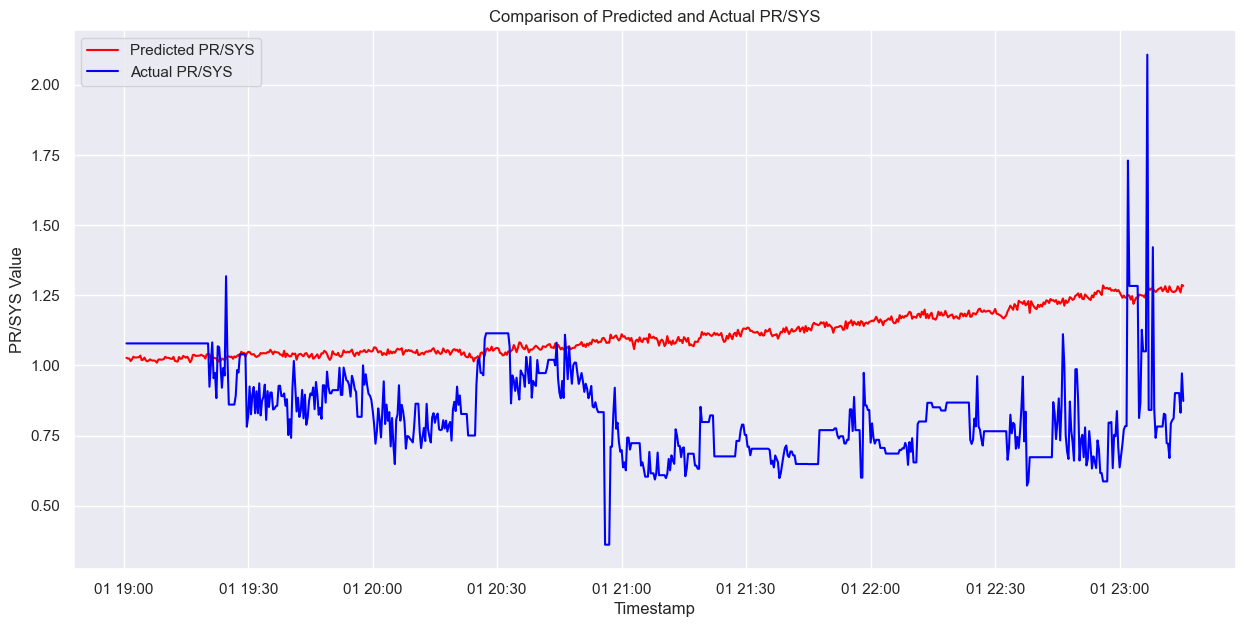

In [132]:
# 确保时间戳索引正确
predictions.reset_index(inplace=True)
test_data.reset_index(inplace=True)


# 确保predictions和test_data包含用于绘图的时间戳列
predictions['timestamp'] = pd.to_datetime(predictions['timestamp'])
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])


# 设置索引
predictions.set_index(['item_id', 'timestamp'], inplace=True)
test_data.set_index(['item_id', 'timestamp'], inplace=True)
# 获取两个数据集中的目标列
predicted_pr_sys = predictions['mean']
actual_pr_sys = test_data['PR/SYS']

# 绘图比较预测值和实际值
plt.figure(figsize=(15, 7))
plt.plot(predicted_pr_sys.index.get_level_values('timestamp'), predicted_pr_sys, label='Predicted PR/SYS', color='red', linestyle='-')
plt.plot(actual_pr_sys.index.get_level_values('timestamp'), actual_pr_sys, label='Actual PR/SYS', color='blue', linestyle='-')
plt.title('Comparison of Predicted and Actual PR/SYS')
plt.xlabel('Timestamp')
plt.ylabel('PR/SYS Value')
plt.legend()
plt.grid(True)
plt.show()

